# Logistic Regression

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.model_selection as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

/Users/crovella/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

So far we have seen linear regression: a continuous valued observation is estimated as linear (or affine) function of the independent variables.

Today we will look at the following situation.

Imagine that you are observing a binary variable -- a 0/1 value.

That is, these could be pass/fail, admit/reject, Democrat/Republican, etc.

You believe that there is some __probability__ of observing a 1, and that probability is a function of certain independent variables.

So the key properties of a problem that make it appropriate for logistic regression are:
    
* What you can observe is a __categorical__ variable
* What you want to estimate is a __probability__ of seeing a particular value of the categorical variable.

## What is the probability I will be admitted to Grad School?

From http://www.ats.ucla.edu/stat/r/dae/logit.htm:

A researcher is interested in how variables, such as _GRE_ (Graduate Record Exam scores), _GPA_ (grade point average) and prestige of the undergraduate institution affect admission into graduate school. The response variable, admit/don't admit, is a binary variable.

There are three predictor variables: __gre,__ __gpa__ and __rank.__ We will treat the variables _gre_ and _gpa_ as continuous. The variable _rank_ takes on the values 1 through 4. Institutions with a rank of 1 have the highest prestige, while those with a rank of 4 have the lowest. 

In [3]:
# data source: http://www.ats.ucla.edu/stat/data/binary.csv
df = pd.read_csv('data/ats-admissions.csv') 
df.head(10)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


In [4]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


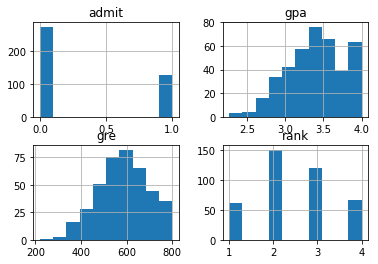

In [5]:
df.hist();

Let's look at how each independent variable affects admission probability.

First, __rank__:

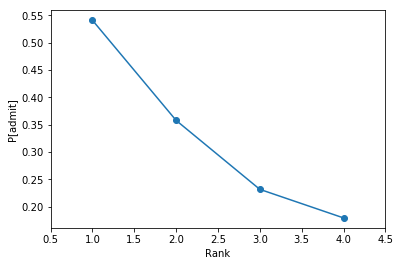

In [6]:
plt.plot(df.groupby('rank').mean()['admit'],'o-')
plt.xlabel('Rank')
plt.xlim([0.5,4.5])
_=plt.ylabel('P[admit]')

Next, __GRE__:

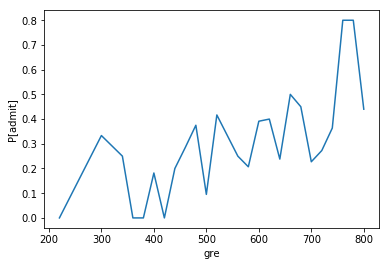

In [7]:
plt.plot(df.groupby('gre').mean()['admit'])
plt.xlabel('gre')
_=plt.ylabel('P[admit]')

Finally, __GPA__ (for this visualization, we aggregate GPA into 10 bins):

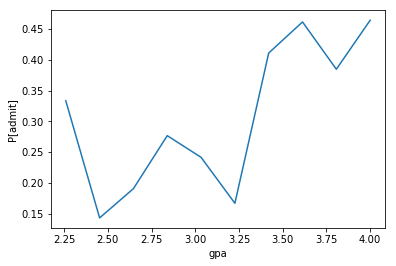

In [8]:
bins = np.linspace(df.gpa.min(), df.gpa.max(), 10)
groups = df.groupby(np.digitize(df.gpa, bins))
plt.plot(bins,groups.admit.mean())
plt.xlabel('gpa')
_=plt.ylabel('P[admit]')

Furthermore, we can see that the independent variables are strongly correlated:

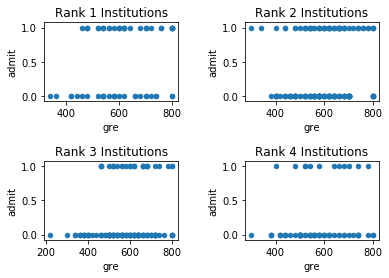

In [9]:
df1 = df[df['rank']==1]
df2 = df[df['rank']==2]
df3 = df[df['rank']==3]
df4 = df[df['rank']==4]
#
ax = plt.subplot(221)
df1.plot.scatter('gre','admit', ax = ax)
plt.title('Rank 1 Institutions')
ax = plt.subplot(222)
df2.plot.scatter('gre','admit', ax = ax)
plt.title('Rank 2 Institutions')
ax = plt.subplot(223)
df3.plot.scatter('gre','admit', ax = ax)
plt.title('Rank 3 Institutions')
ax = plt.subplot(224)
plt.title('Rank 4 Institutions')
df4.plot.scatter('gre','admit', ax = ax)
plt.subplots_adjust(hspace=0.75,wspace=0.5)

## Logistic Regression

Logistic regression is concerned with estimating a __probability.__

However, all that is available are categorical observations, which we will code as 0/1.

That is, these could be pass/fail, admit/reject, Democrat/Republican, etc.

Now, a linear function like $\alpha + \beta x$ cannot be used to predict probability directly, because the linear function takes on all values (from -$\infty$ to +$\infty$), and probability only ranges over $(0, 1)$.

However, there is a transformation of probability that works: it is called __log-odds__.

For any probabilty $p$, the __odds__ is defined as $p/(1-p)$.   Notice that odds vary from 0 to $\infty$, and odds < 1 indicates that $p < 1/2$.

Now, there is a good argument that to fit a linear function, instead of using odds, we should use log-odds.  That is simply $\log p/(1-p)$.

So, logistic regression does the following: it does a linear regression of $\alpha + \beta x$ against $\log p/(1-p)$.

That is, it fits:

$$\alpha + \beta x = \log \frac{p(x)}{1-p(x)}$$

$$e^{\alpha + \beta x} = \frac{p(x)}{1-p(x)}$$

$$e^{\alpha + \beta x} (1-p(x)) = p(x)$$

$$e^{\alpha + \beta x}  = p(x) + p(x)e^{\alpha + \beta x}$$

$$\frac{e^{\alpha + \beta x}}{1 +e^{\alpha + \beta x}} = p(x)$$

So, logistic regression fits a probability of the following form:
        $$p(x) = P(y=1\mid x) = \frac{e^{\alpha+\beta x}}{1+e^{\alpha+\beta x}}$$
        
This is a sigmoid function; when $\beta > 0$, $x\rightarrow \infty$, then $p(x)\rightarrow 1$ and when $x\rightarrow -\infty$, then $p(x)\rightarrow 0$.

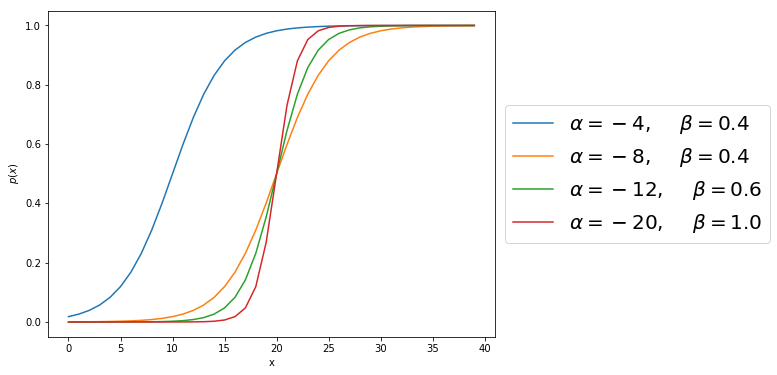

In [10]:
alphas = [-4, -8,-12,-20]
betas = [0.4,0.4,0.6,1]
x = np.arange(40)
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(111)

for i in range(len(alphas)):
    a = alphas[i]
    b = betas[i]
    y = np.exp(a+b*x)/(1+np.exp(a+b*x))
#     plt.plot(x,y,label=r"$\frac{e^{%d + %3.1fx}}{1+e^{%d + %3.1fx}}\;\alpha=%d, \beta=%3.1f$" % (a,b,a,b,a,b))
    plt.plot(x,y,label=r"$\alpha=%d,$    $\beta=%3.1f$" % (a,b))
plt.xlabel('x')
plt.ylabel('$p(x)$')
_=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 20})

Parameter $\beta$ controls how fast $p(x)$ raises from $0$ to $1$

The value of -$\alpha$/$\beta$ shows the value of $x$ for which $p(x)=0.5$

Another interpretation of $\alpha$ is that it gives the __base rate__ -- the unconditional probability of a 1.   That is, if you knew nothing about a particular data item, then $p(x) = 1/(1+e^{-\alpha})$.

The function $f(x) = \log (x/(1-x))$ is called the __logit__ function.

So a compact way to describe logistic regression is that it finds regression coefficients $\alpha, \beta$ to fit:

$$\text{logit}\left(p(x)\right)=\log\left(\frac{p(x)}{1-p(x)} \right) = \alpha + \beta x$$

Note also that the __inverse__ logit function is:

$$\text{logit}^{-1}(x) = \frac{e^x}{1 + e^x}$$

Somewhat confusingly, this is called the __logistic__ function.

So, the best way to think of logistic regression is that we compute a linear function:
    
$$\alpha + \beta x$$
    
and then "map" that to a probability using the $\text{logit}^{-1}$ function:

$$\frac{e^{\alpha+\beta x}}{1+e^{\alpha+\beta x}}$$

## Logistic vs Linear Regression

Let's take a moment to compare linear and logistic regression.

In **Linear regression ** we fit 

$$y_i = \alpha +\beta x_i + \epsilon_i.$$

We do the fitting by minimizing the sum of squared error ($\Vert\epsilon\Vert$).   This can be done in closed form.  

(Recall that the closed form is found by geometric arguments, or by calculus).

Now, if $\epsilon_i$ comes from a normal distribution with mean zero and some fixed variance, 

then minimizing the sum of squared error is exactly the same as finding the maximum likelihood of the data with respect to the probability of the errors.

So, in the case of linear regression, it is a lucky fact that the __MLE__ of $\alpha$ and $\beta$ can be found by a __closed-form__ calculation.

In **Logistic regression ** we fit 

$$\text{logit}(p(x_i)) = \alpha + \beta x_i.$$


with $\text{Pr}(y_i=1\mid x_i)=p(x_i).$

How should we choose parameters?   

Here too, we use Maximum Likelihood Estimation of the parameters.

That is, we choose the parameter values that maximize the likelihood of the data given the model.

$$ \text{Pr}(y_i \mid x_i) = \left\{\begin{array}{lr}\text{logit}^{-1}(\alpha + \beta x_i)& \text{if } y_i = 1\\
1 - \text{logit}^{-1}(\alpha + \beta x_i)& \text{if } y_i = 0\end{array}\right.$$

We can write this as a single expression:

$$\text{Pr}(y_i \mid x_i) = \text{logit}^{-1}(\alpha + \beta x_i)^{y_i} (1-\text{logit}^{-1}(\alpha + \beta x_i))^{1-y_i} $$

We then use this to compute the __likelihood__ of parameters $\alpha$, $\beta$:

$$L(\alpha, \beta \mid x_i, y_i) = \text{logit}^{-1}(\alpha + \beta x_i)^{y_i} (1-\text{logit}^{-1}(\alpha + \beta x_i))^{1-y_i}$$

which is a function that we can maximize via various kinds of gradient descent.

## Logistic Regression In Practice

So, in summary, we have:

**Input** pairs $(x_i,y_i)$

**Output** parameters $\widehat{\alpha}$ and $\widehat{\beta}$ that maximize the likelihood of the data given these parameters for the logistic regression model.

**Method** Maximum likelihood estimation, obtained by gradient descent.

The standard package will give us a correlation coefficient (a $\beta_i$) for each independent variable (feature).

If we want to include a constant (ie, $\alpha$) we need to add a column of 1s (just like in linear regression).

In [11]:
df['intercept'] = 1.0
train_cols = df.columns[1:]
train_cols

Index(['gre', 'gpa', 'rank', 'intercept'], dtype='object')

In [12]:
logit = sm.Logit(df['admit'], df[train_cols])
 
# fit the model
result = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6


In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 Nov 2017   Pseudo R-squ.:                 0.08107
Time:                        10:38:45   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 8.207e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.101      0.036       0.000       0.004
gpa            0.7770      0.327      2.373      0.018       0.135       1.419
rank          -0.5600      0.127     -4.405      0.000      -0.809      -0.311
intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
==============================================================================
"""

Notice that all of our independent variables are considered significant (no confidence intervals contain zero).

## Using the Model

Note that by fitting a model to the data, we can make predictions for inputs that were never seen in the data.  

Furthermore, we can make a prediction of a probability for cases where we don't have enough data to estimate the probability directly -- e.g, for specific parameter values.

Let's see how well the model fits the data.

We have three independent variables, so in each case we'll use average values for the two that we aren't evaluating.

GPA:

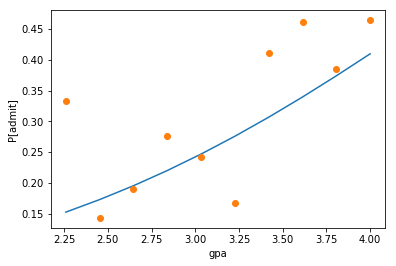

In [14]:
bins = np.linspace(df.gpa.min(), df.gpa.max(), 10)
groups = df.groupby(np.digitize(df.gpa, bins))
prob = [result.predict([600, b, 2.5, 1.0]) for b in bins]
plt.plot(bins, prob)
plt.plot(bins,groups.admit.mean(),'o')
plt.xlabel('gpa')
plt.ylabel('P[admit]');

GRE Score:

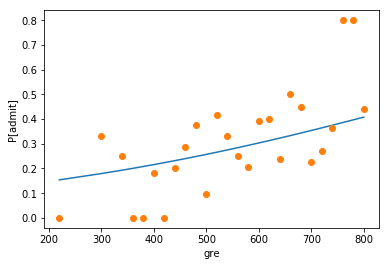

In [15]:
prob = [result.predict([b, 3.4, 2.5, 1.0]) for b in sorted(df.gre.unique())]
plt.plot(sorted(df.gre.unique()), prob)
plt.plot(df.groupby('gre').mean()['admit'],'o')
plt.xlabel('gre')
plt.ylabel('P[admit]');

Institution Rank:

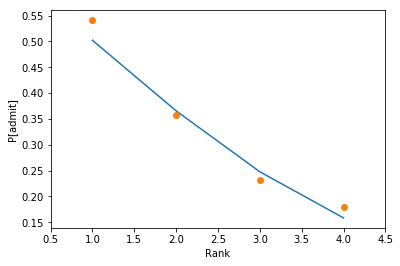

In [16]:
prob = [result.predict([600, 3.4, b, 1.0]) for b in range(1,5)]
plt.plot(range(1,5), prob)
plt.plot(df.groupby('rank').mean()['admit'],'o')
plt.xlabel('Rank')
plt.xlim([0.5,4.5])
_=plt.ylabel('P[admit]')

## Logistic Regression in Perspective

At the start of lecture I emphasized that logistic regression is concerned with estimating a __probability__ model from __discrete__ (0/1) data. 

However, it may well be the case that we want to do something with the probability that amounts to __classification.__

For example, we may classify data items using a rule such as "Assign item $x_i$ to Class 1 if $p(x_i) > 0.5$".

For this reason, logistic regression could be considered a classification method.

In fact, that is what we did with Naive Bayes -- we used it to estimate something like a probability, and then chose the class with the maximum value to create a classifier.

Let's use our logistic regression as a classifier.

We want to ask whether we can correctly predict whether a student gets admitted to graduate school.

Let's separate our training and test data:

In [17]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        df[train_cols], df['admit'],
        test_size=0.4, random_state=1)

Now, there are some standard metrics used when evaluating a binary classifier.

Let's say our classifier is outputting "yes" when it thinks the student will be admitted.

There are four cases:
* Classifier says "yes", and student __is__ admitted:  __True Positive.__
* Classifier says "yes", and student __is not__ admitted:  __False Positive.__
* Classifier says "no", and student __is__ admitted:  __False Negative.__
* Classifier says "no", and student __is not__ admitted:  __True Negative.__

__Precision__ is the fraction of "yes"es that are correct:
    $$\mbox{Precision} = \frac{\mbox{True Positives}}{\mbox{True Positives + False Positives}}$$
    
__Recall__ is the fraction of admits that we say "yes" to:
 $$\mbox{Recall} = \frac{\mbox{True Positives}}{\mbox{True Positives + False Negatives}}$$

In [18]:
def evaluate(y_train, X_train, y_test, X_test, threshold):

    # learn model on training data
    logit = sm.Logit(y_train, X_train)
    result = logit.fit(disp=False)
    
    # make probability predictions on test data
    y_pred = result.predict(X_test)
    
    # threshold probabilities to create classifications
    y_pred = y_pred > threshold
    
    # report metrics
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    return precision, recall

precision, recall = evaluate(y_train, X_train, y_test, X_test, 0.5)

print('\nPrecision: {:0.3f}, Recall: {:0.3f}'.format(precision,recall))


Precision: 0.586, Recall: 0.340


Now, let's get a sense of average accuracy:

In [19]:
PR = []
for i in range(20):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
            df[train_cols], df['admit'],
            test_size=0.4)
    PR.append(evaluate(y_train, X_train, y_test, X_test, 0.5))

In [20]:
avgPrec = np.mean([f[0] for f in PR])
avgRec = np.mean([f[1] for f in PR])
print('\nAverage Precision: {:0.3f}, Average Recall: {:0.3f}'.format(avgPrec, avgRec))


Average Precision: 0.624, Average Recall: 0.230


Sometimes we would like a single value that describes the overall performance of the classifier.

For this, we take the harmonic mean of precision and recall, called __F1 Score__:

$$\mbox{F1 Score} = 2 \;\;\frac{\mbox{Precision} \cdot \mbox{Recall}}{\mbox{Precision} + \mbox{Recall}}$$

Using this, we can evaluate other settings for the threshold.

In [21]:
import warnings
warnings.filterwarnings("ignore")
def evalThresh(df, thresh):
    PR = []
    for i in range(20):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                df[train_cols], df['admit'],
                test_size=0.4)
        PR.append(evaluate(y_train, X_train, y_test, X_test, thresh))
    avgPrec = np.mean([f[0] for f in PR])
    avgRec = np.mean([f[1] for f in PR])
    return 2 * (avgPrec * avgRec) / (avgPrec + avgRec), avgPrec, avgRec

tvals = np.linspace(0.05, 0.8, 50)
f1vals = [evalThresh(df, tval)[0] for tval in tvals]

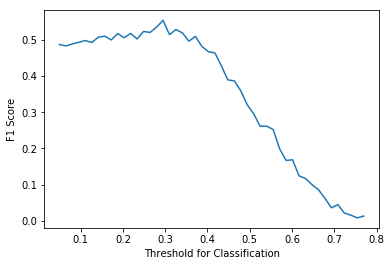

In [22]:
plt.plot(tvals,f1vals)
plt.ylabel('F1 Score')
_=plt.xlabel('Threshold for Classification')

Based on this plot, we can say that the best classification threshold appears to be around 0.3, where precision and recall are:

In [23]:
F1, Prec, Rec = evalThresh(df, 0.3)
print('Best Precision: {:0.3f}, Best Recall: {:0.3f}'.format(Prec, Rec))

Best Precision: 0.414, Best Recall: 0.681


The example here is based on
http://blog.yhathq.com/posts/logistic-regression-and-python.html
where you can find additional details.